# Objectives

1. Plot heat map style of branch major

---
# Setup

## Imports

In [113]:
import os
import dill
from Bio import Phylo
import copy
import math

from matplotlib import lines

## File Paths

In [124]:
# jupyter notebook output
tree_df_dill = "../../results/mugration/mugration.df.obj"
tree_dill = "../../results/mugration/mugration.treetime.obj"

auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"

outdir = "../../results/misc/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [125]:
from config import *

#NAME_COL = "Sample"
NAME_COL = "Name"
SCRIPT_NAME = "misc"

## Import Tree

In [9]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [10]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False,0,1,8.55565e-08,0.PRE,0.998731,0.00977069,0.PRE2,0.392436,1.32907,Russia,0.99242,0.0484304,64.6863,97.7453,Krasnoyarsk Krai,0.382138,1.65207,63.3234,97.098
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False,0,1,-1.00009e-12,0.PRE,1,-9.99867e-13,0.PRE2,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Krasnoyarsk Krai,1,-1.00009e-12,63.3234,97.098
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False,0,1,8.55565e-08,0.PRE,0.999998,2.33079e-05,0.PRE1,0.999213,0.00727438,Russia,0.977706,0.136133,64.6863,97.7453,Panevezys County,0.442487,1.9261,55.9156,25.0312
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False,0,1,-1.00009e-12,0.PRE,1,-1.00009e-12,0.PRE1,1,-1.00009e-12,Lithuania,1,-1.00009e-12,55.35,23.75,Panevezys County,1,-1.00009e-12,55.9156,25.0312
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False,0,1,8.55565e-08,0.PRE,1,2.10548e-07,0.PRE1,0.999999,1.69062e-05,Russia,0.97708,0.14249,64.6863,97.7453,Pärnu maakond,0.442563,1.92163,58.3195,24.3026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,6.56282e-05,541.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False,1,1,8.35157e-08,1.ORI,1,2.02107e-07,1.ORI1,1,9.61593e-07,United States 

## Import Colors

In [56]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
colors_df

,Attribute,State,Color
0,branch_number,0,#8000ff
1,branch_number,3,#00b4ec
2,branch_number,4,#80ffb4
3,branch_number,2,#ffb462
4,branch_number,1,#ff0000
...,...,...,...
202,province,Midlands,#ff1c0e
203,province,State of Mato Grosso,#ff150b
204,province,MSila,#ff0e07
205,province,La Paz,#ff0704


---
# 1. Plot Branch Major

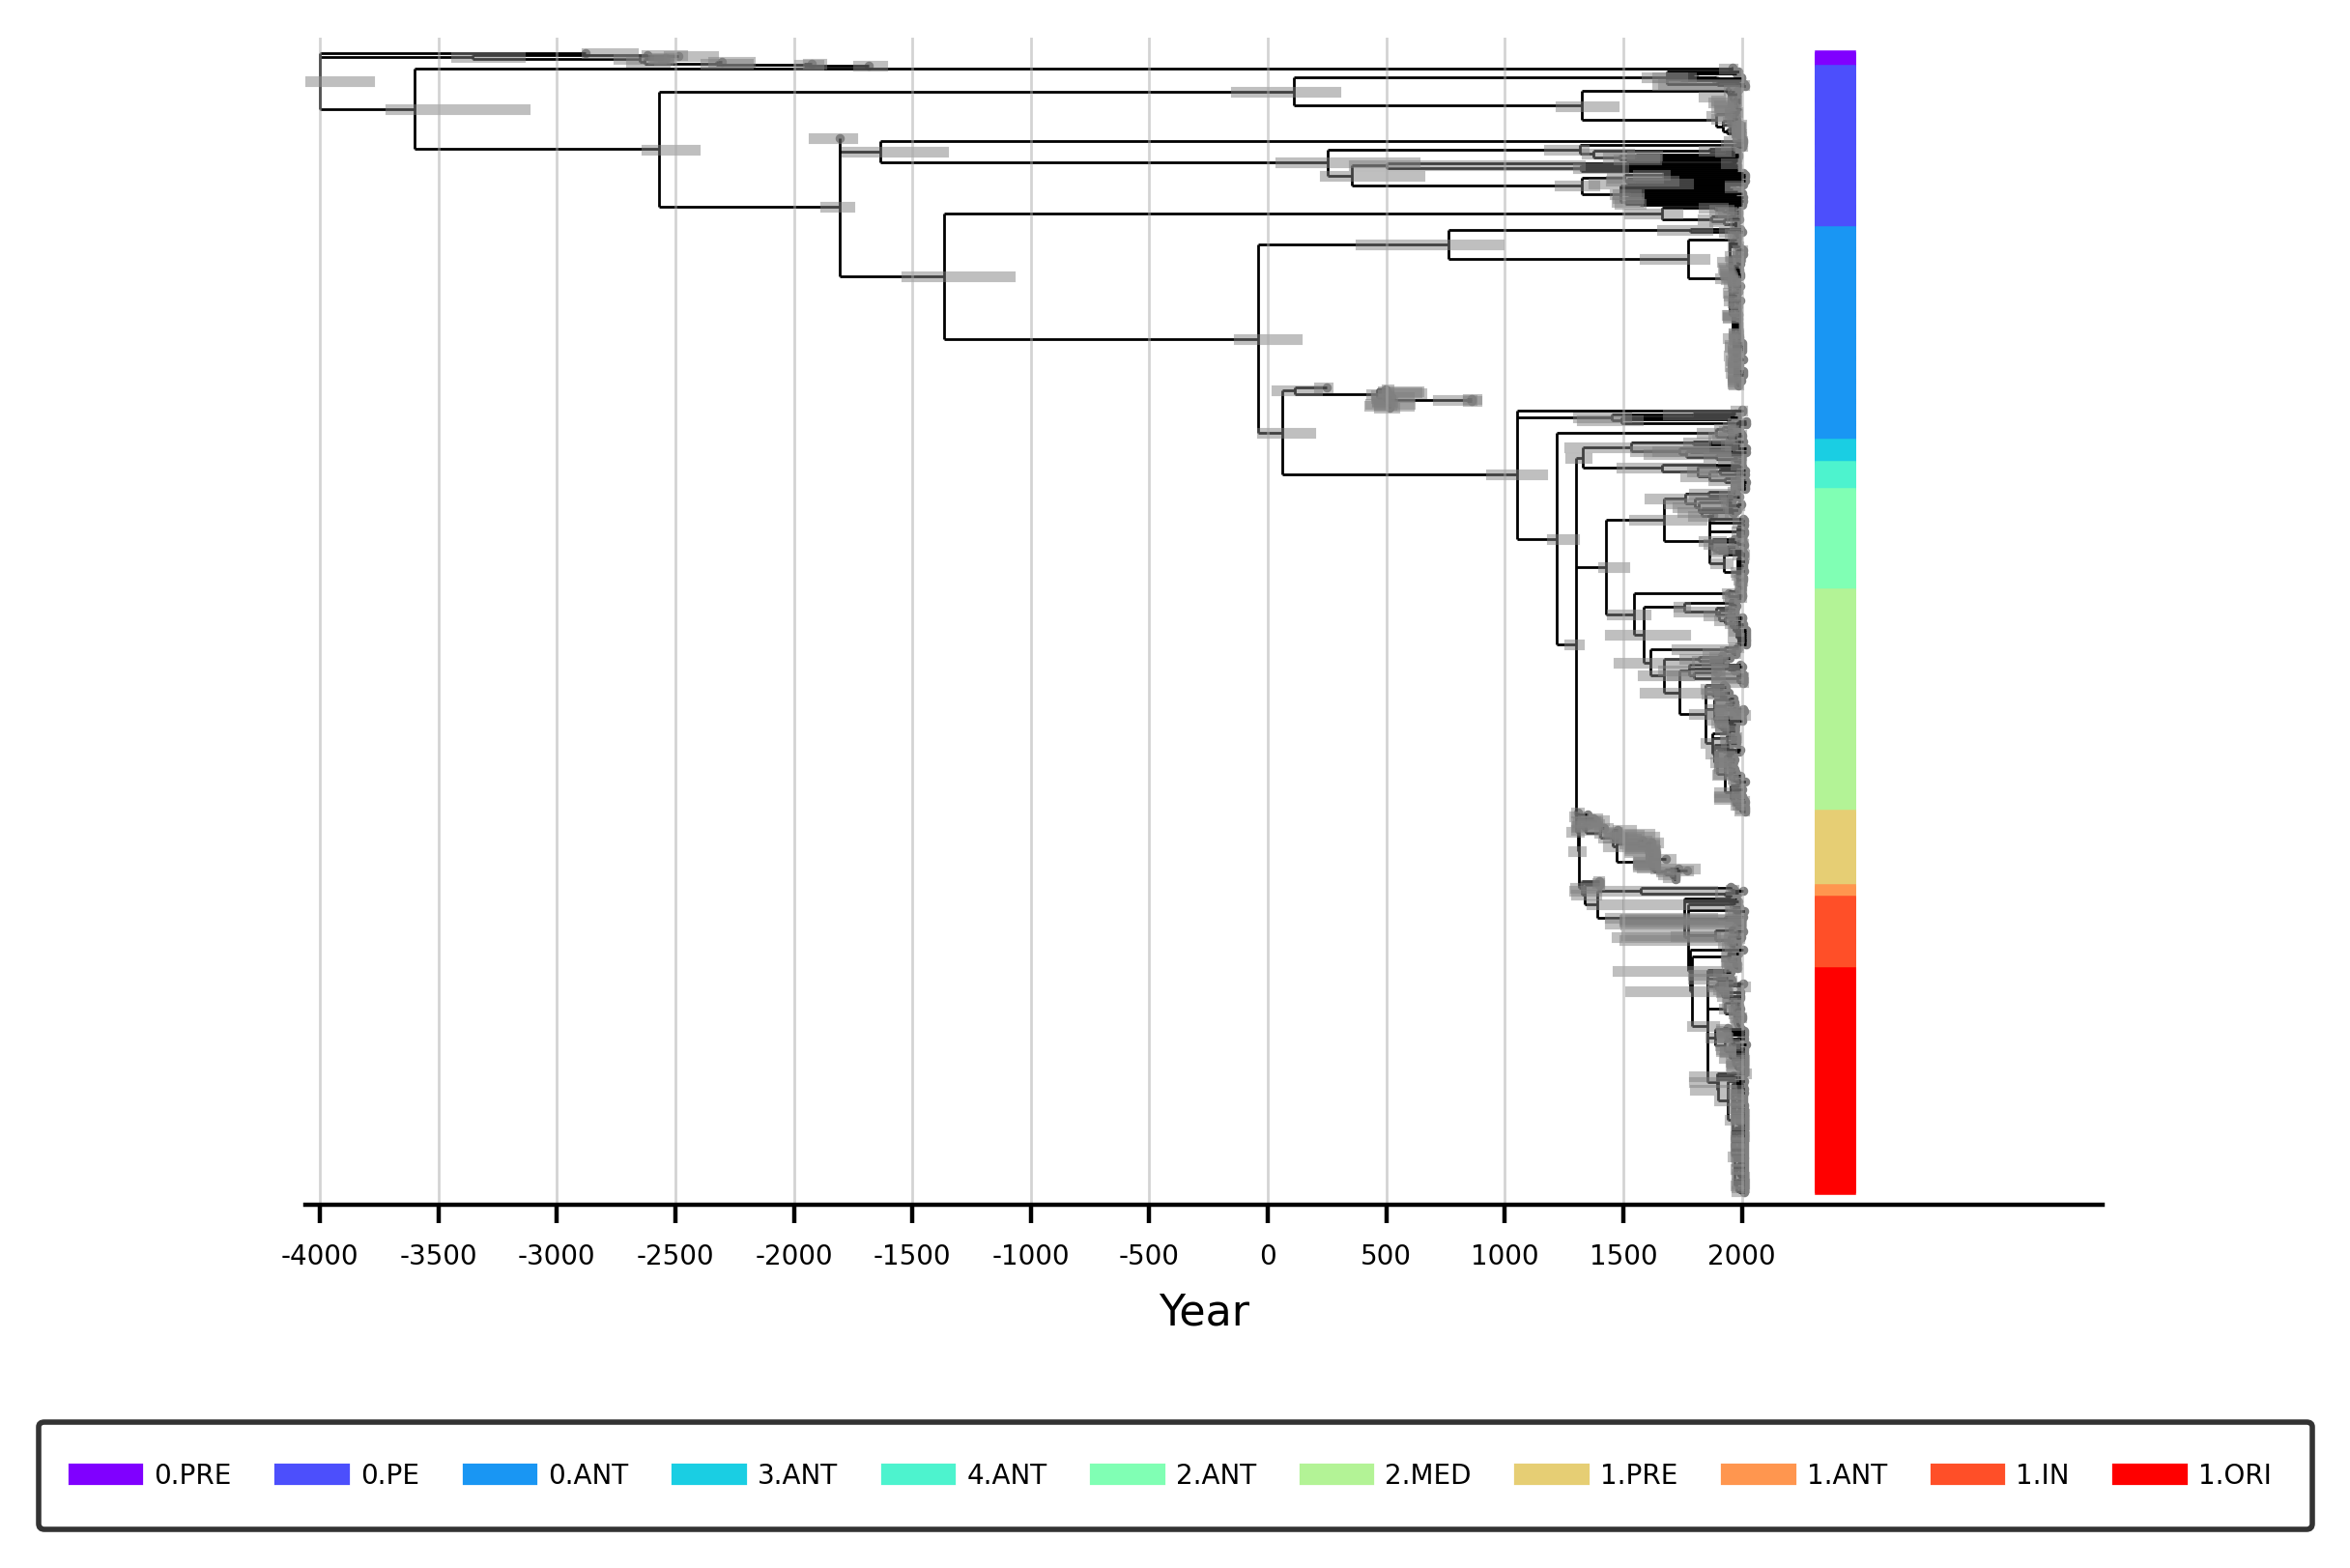

In [127]:
# Plot setup
fig, ax1 = plt.subplots(1, dpi=dpi)

# Colors Setup
attr = "Branch_Major"
attr_lower = attr.lower()
attr_colors_df = colors_df[colors_df["Attribute"] == attr_lower][["State","Color"]]
attr_colors_dict = {}
for rec in attr_colors_df.iterrows():
    state = rec[1]["State"]
    color = rec[1]["Color"]
    attr_colors_dict[state] = color

tt_copy = copy.deepcopy(tt)

# --------------------------------------------
# Phylogeny
Phylo.draw(tt_copy.tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

# Node Bars
x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax1.plot([bar_lower, bar_upper], [y,y], alpha=0.5, c="grey", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower
            
# --------------------------------------------
# Heatmap
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
ax1.scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")
heatmap_x = 0.00012

# Heatmap x coordinates will stay the same
heatmap_x_buffer = max(tree_df["timetree_coord_x"]) * 0.05
heatmap_x1 = max(tree_df["timetree_coord_x"]) + heatmap_x_buffer
heatmap_x2 = max(tree_df["timetree_coord_x"]) + (1.5 * heatmap_x_buffer)

for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1][attr]
    color = attr_colors_dict[state]
    ax1.plot([heatmap_x1, heatmap_x2], [y,y], alpha=1, c=color, linewidth=1)
    

# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
# Leave out last one
ax1.set_xticks(ticks_dict["tick_locs"][:-1])
ax1.set_xticklabels(ticks_dict["tick_labels"][:-1])
  
# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"][:-1]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits
ax1.set_xlim(0 - x_buffer,)    
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)
ax1.set_yticks([])    
# --------------------------------------------
# Labels
ax1.set_xlabel("Year")
ax1.set_ylabel("")
#fig.suptitle("{} Mugration".format(attr.replace("_"," ")))  
# --------------------------------------------
# Frames
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# -------------------------------
# Legend

legend_lines = [lines.Line2D([0], [0], color=attr_colors_dict[state], lw=4, label="test") 
                for state in attr_colors_dict]
legend_labels = [state for state in attr_colors_dict]
fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-branch-major." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")